In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Cleaning

In [2]:
as_df = pd.read_csv("../Data/aspiny_human_me_wide.csv")
as_df = as_df.sort_values('specimen_id')

In [3]:
import re

#Integrate qualitative calls as ground truth clusters
qc = pd.read_csv("../Data/H301_reconstructions_with_Metadata_QC.csv")
qc = qc[qc['dendrite_type'].str.contains("aspiny")].dropna(subset=['Morpho type'])
qc = qc.join(as_df.set_index('specimen_id'), on='cell_specimen_id', sort=True).dropna()
for i, row in qc.iterrows():
    if row['Morpho type'].startswith('BC - stellate'):
        qc.at[i, 'Morpho type'] = 'BC - STELLATE'
    elif row['Morpho type'].startswith('BC - bituft'):
        qc.at[i, 'Morpho type'] = 'BC - BITUFT'
qc['Morpho type'] = qc['Morpho type'].str.upper()
qc = qc.reset_index(drop=True)

#Check qualitative cluster sizes, remove cells that have only one sample
mt_counts = qc['Morpho type'].value_counts()
display(mt_counts)
qc = qc[qc['Morpho type'].isin(mt_counts[mt_counts > 1].index)]

BC - STELLATE            10
BIC                       9
BC - BITUFT               9
MARTINOTTI                1
BC - SMALL - ASC. AX.     1
MELROSE                   1
NON - MARTINOTTI          1
Name: Morpho type, dtype: int64

In [4]:
mt_clusters = qc['Morpho type'].unique()
print('Unique Morpho Types: ', mt_clusters)

('Unique Morpho Types: ', array(['BC - STELLATE', 'BC - BITUFT', 'BIC'], dtype=object))


In [5]:
as_df = as_df[as_df['specimen_id'].isin(qc['cell_specimen_id'])]

# Analysis

## Plotting Correlation Matrices

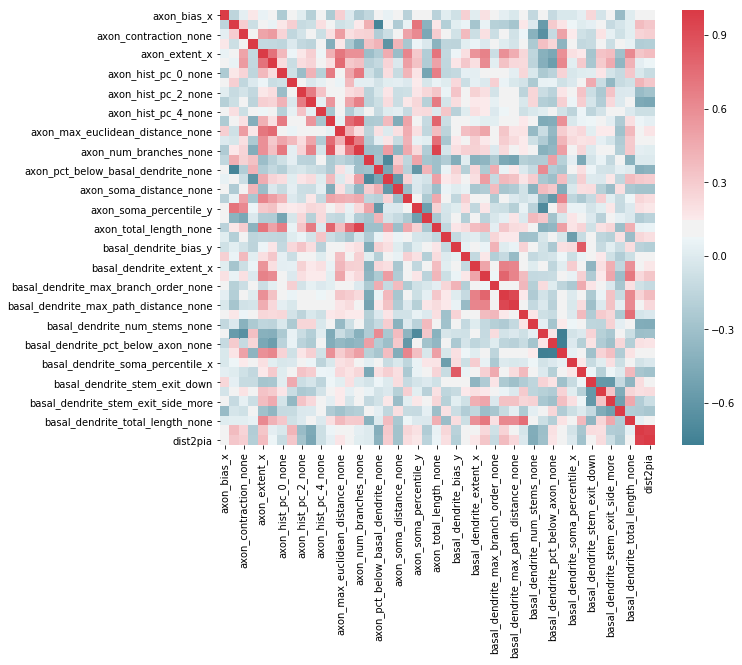

In [6]:
# Plotting features
def plotcorr(df):
    f, ax = plt.subplots(figsize=(10,8))
    corr = df.iloc[:, 1:].corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap = sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax)

plotcorr(as_df)

Take highly correlated features out (threshold of 0.90)

In [7]:
def correlate(df):
    corr_matrix = df.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(upper[column] > 0.9)]

as_to_drop = correlate(as_df)
as_df = as_df.drop(as_df.loc[:,as_to_drop], axis=1)
as_to_drop

['axon_total_length_none', 'basal_dendrite_max_path_distance_none', 'dist2pia']

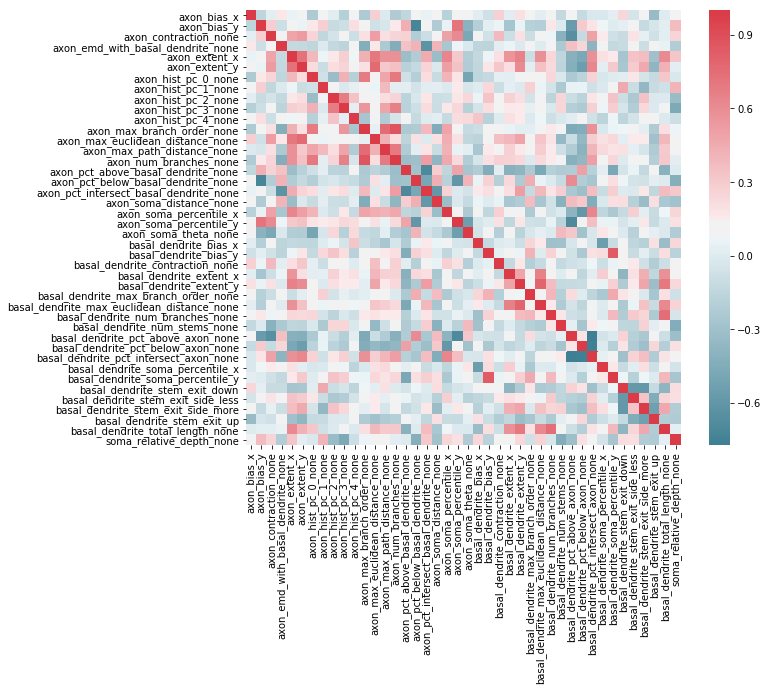

In [8]:
plotcorr(as_df)

## Conduct PCA to determine variance

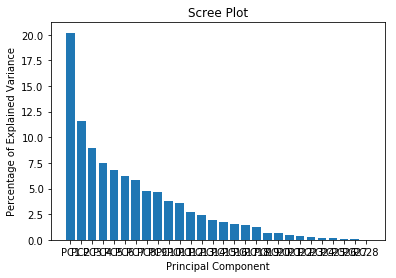

,feature,loading score
5,axon_extent_x,0.303263
15,axon_num_branches_none,0.261538
6,axon_extent_y,0.256686
34,basal_dendrite_pct_intersect_axon_none,0.255520
12,axon_max_branch_order_none,0.222557
27,basal_dendrite_extent_y,0.207805
41,basal_dendrite_total_length_none,0.206427
14,axon_max_path_distance_none,0.206002
20,axon_soma_percentile_x,0.205803
18,axon_pct_intersect_basal_dendrite_none,0.201914


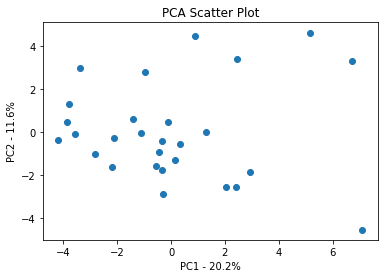

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the Data
scaled_data = StandardScaler().fit_transform(as_df)

pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()
    
pca_df = pd.DataFrame(pca_data, columns=labels)
    
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('PCA Scatter Plot')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

pca = PCA()
pca.fit(scaled_data)
loading_scores = pd.Series(pca.components_[0])
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
top_10_feats = sorted_loading_scores[0:10].index.values

pd.DataFrame({'feature' : [list(as_df)[i] for i in top_10_feats], 'loading score' : sorted_loading_scores[top_10_feats]})

### K-Means Clustering

#### Elbow Method

In [10]:
import sklearn.cluster as skc

cluster_range = range(1,20)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = skc.KMeans(num_clusters)
    clusters.fit(scaled_data)
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({'num_clusters':cluster_range, 'cluster_errors': cluster_errors})
clusters_df[0:10]

,cluster_errors,num_clusters
0,1204.000000,1
1,1041.907717,2
2,965.407463,3
3,887.836531,4
4,814.454595,5
5,718.530235,6
6,654.985566,7
7,576.969808,8
8,493.982444,9
9,458.177670,10


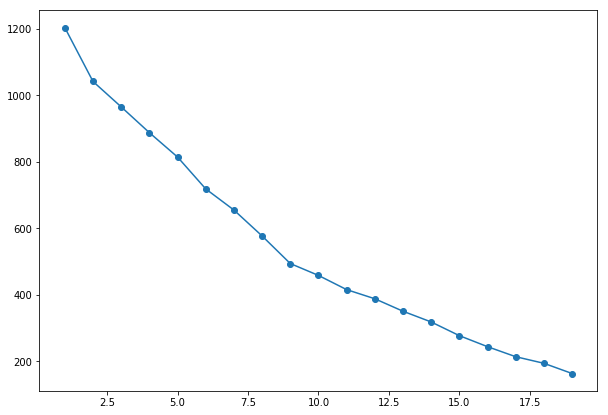

In [11]:
plt.figure(figsize=(10,7))
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors, marker = 'o')

Plot does not show a distinct elbow pivot. Therefore, I will now apply silhouette analysis and gap statistic as alternative approaches to determining the optimal number of clusters.
#### Silhouette Analysis
A silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visua
lly. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

('For n_clusters =', 2, 'The average silhouette_score is :', 0.26326892306288713)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.11051519079872658)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.07313833845278353)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.079464024348741544)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.069311854124371325)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.065017252163117711)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.060086203825233983)


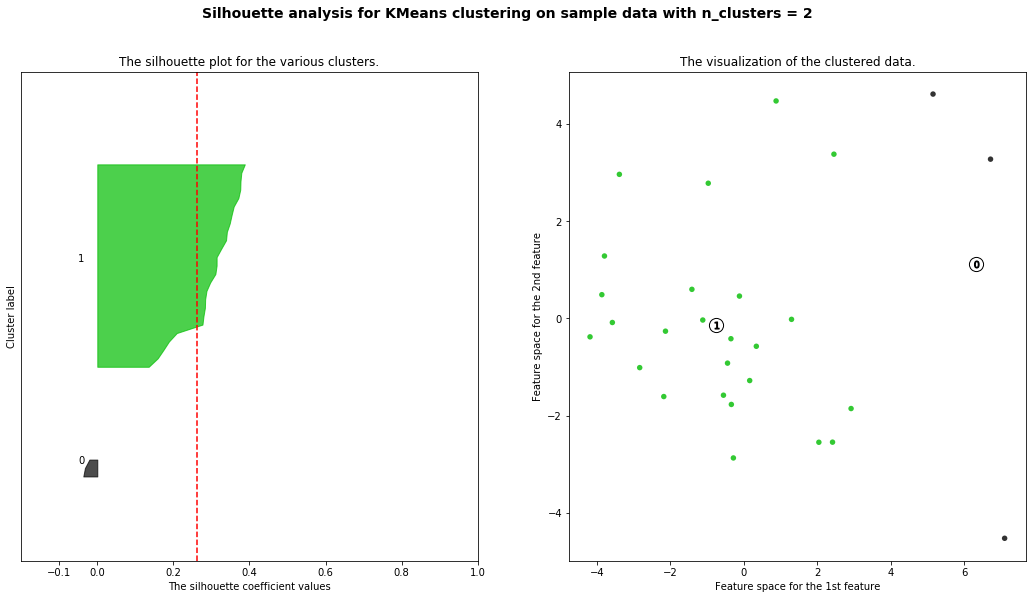

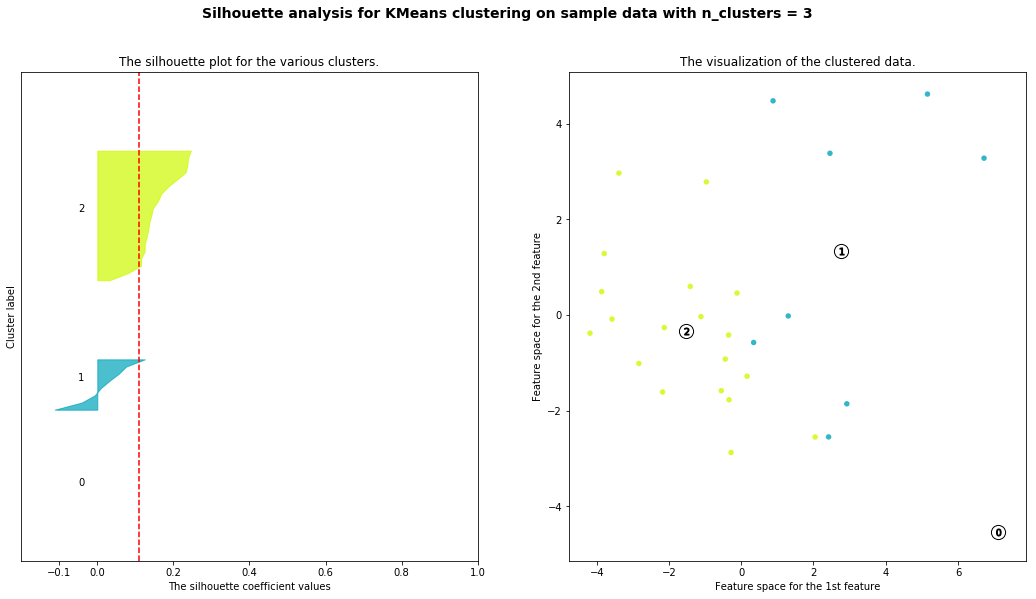

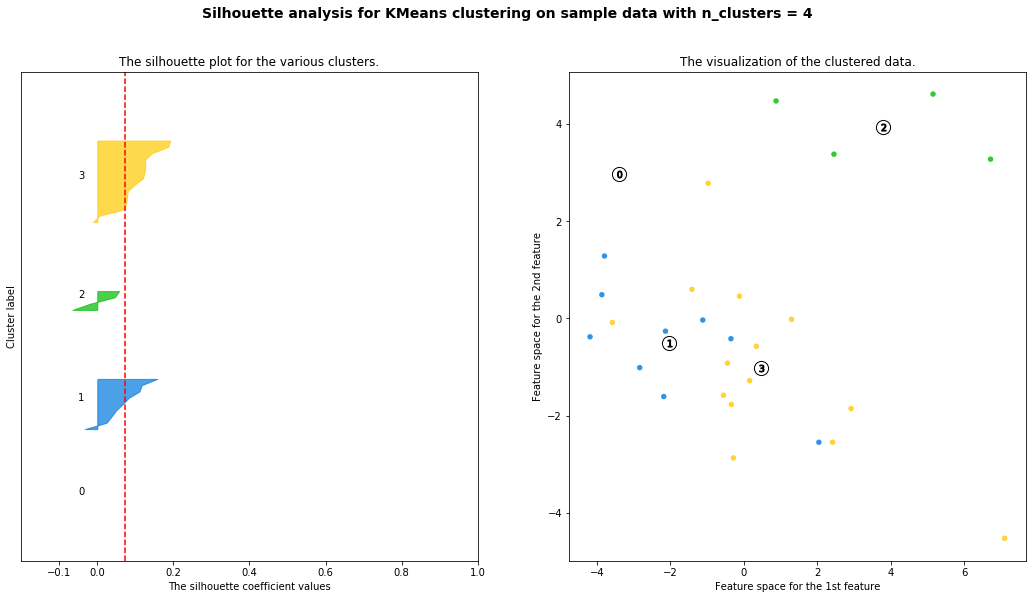

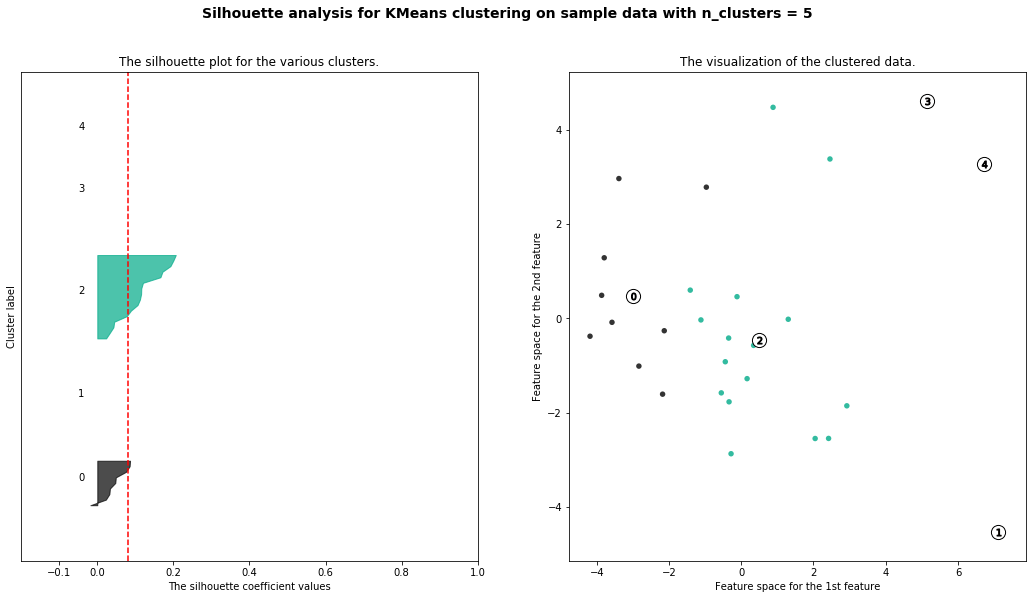

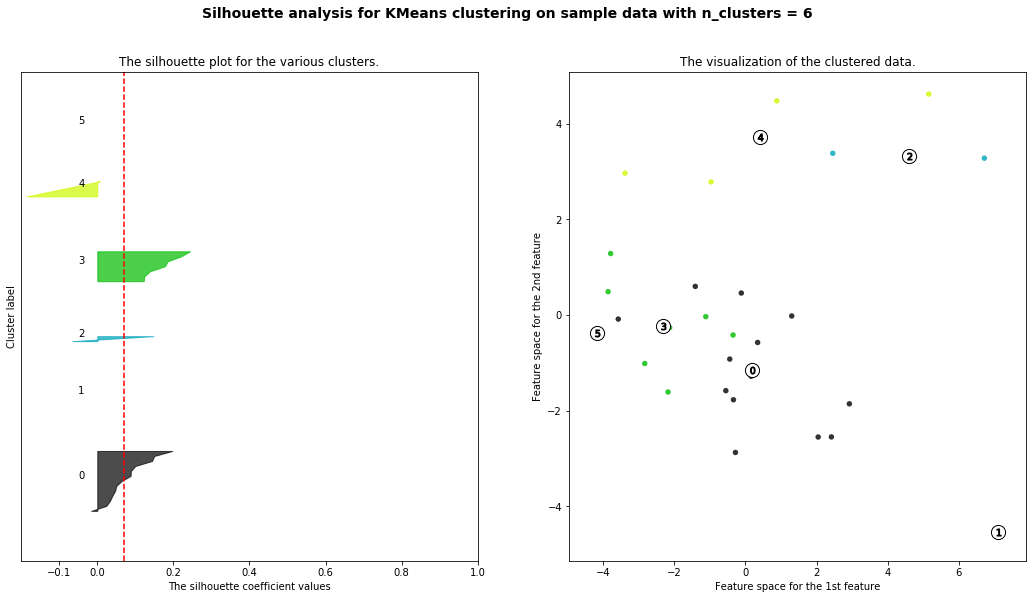

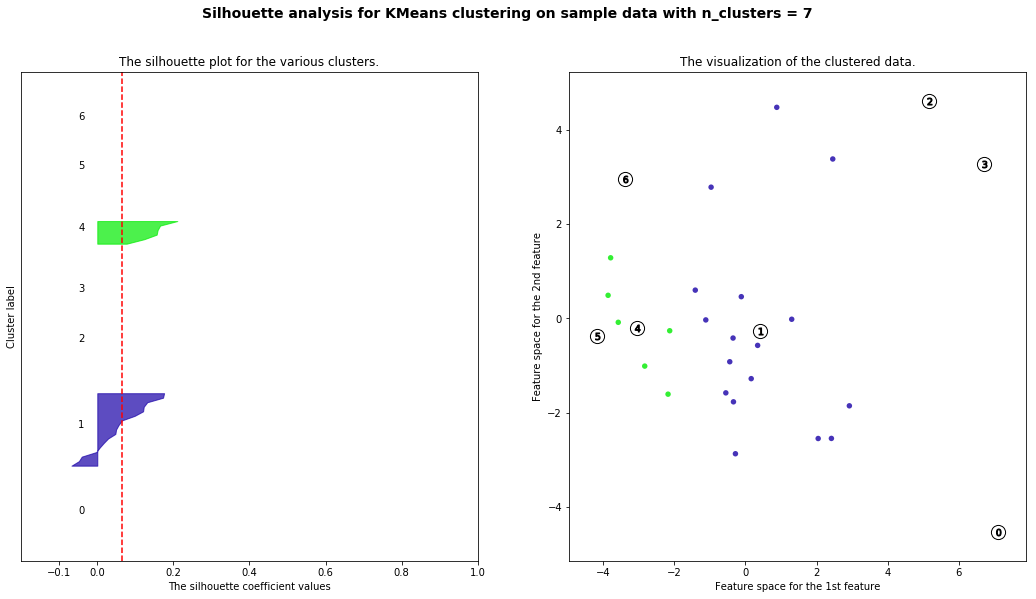

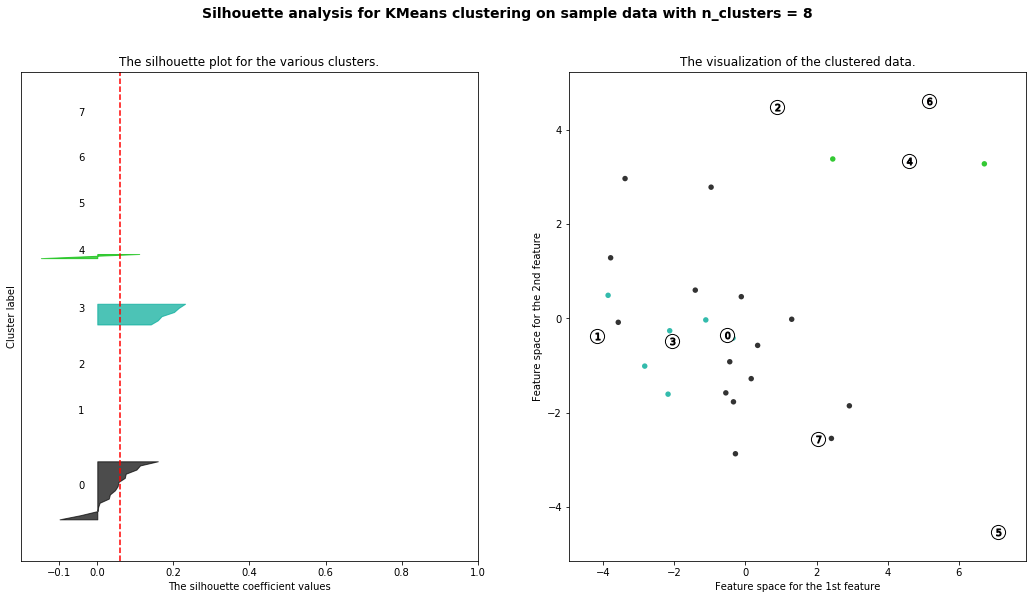

In [12]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm

range_n_clusters = range(2, 9)
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18,9)
    
    # 1st subplot is the silhouette plot
    # the silhouette coefficient can range from -1, 1; in this example, the lower bound only appears to be -0.1. 
    ax1.set_xlim([-0.2,1])
    ax1.set_ylim([0, len(pca_df) + (n_clusters + 1) * 10])
    
    cluster = skc.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = cluster.fit_predict(pca_df)
    
    # silhouette_score gives average value for all the samples
    # gives perspective into the density and separation of the formed
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    print("For n_clusters =", n_clusters, 
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pca_df, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(pca_df.PC1, pca_df.PC2, marker='o', s=30, lw=0, alpha=0.8,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = cluster.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


Silhouette analysis suggests two clusters.

I will also try gap statistic to see if there is a more robust optimization.
#### Gap Statistic

In [13]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = skc.KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = skc.KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal
    

In [14]:
k, gapdf = optimalK(pca_df, nrefs=3, maxClusters=15)
print('Optimal k is: ', k)

('Optimal k is: ', 13)


Results of the calculated gaps: the higher the value, the more optimal it is

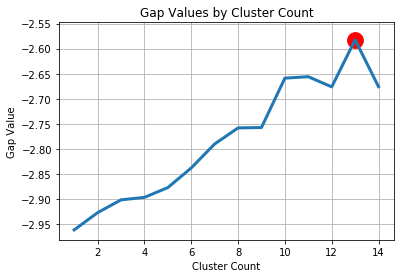

In [15]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

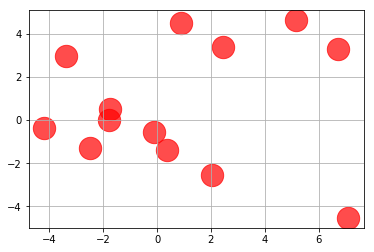

In [16]:
km = skc.KMeans(k)
km.fit(pca_df)

df = pd.DataFrame(pca_df, columns=['x','y'])
df['label'] = km.labels_

colors = plt.cm.Spectral(np.linspace(0, 1, len(df.label.unique())))

for color, label in zip(colors, df.label.unique()):
    
    tempdf = df[df.label == label]
    plt.scatter(tempdf.x, tempdf.y, c=color)
    
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], c='r', s=500, alpha=0.7, )
plt.grid(True)
plt.show()

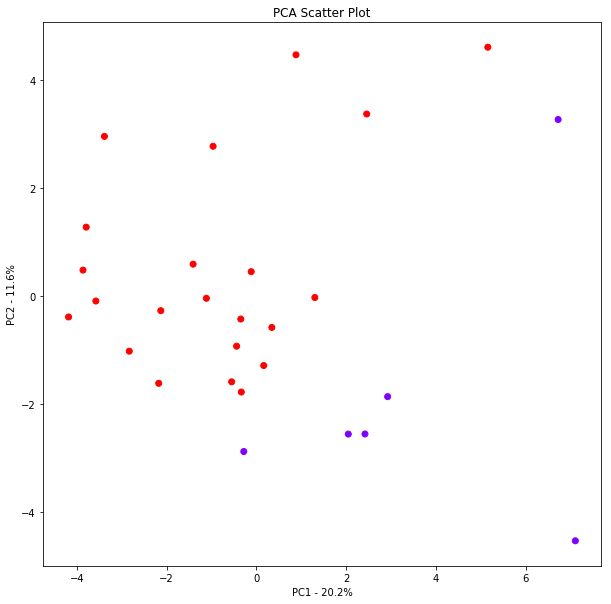

In [17]:
kM_cluster = skc.KMeans(n_clusters=2)
kM_cluster.fit_predict(pca_df)

plt.figure(figsize=(10,10))
plt.scatter(pca_df.PC1, pca_df.PC2, c=kM_cluster.labels_, cmap='rainbow')
plt.title('PCA Scatter Plot')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.show()

### Mean-Shift Clustering

In [18]:
from itertools import cycle

#compute clustering
bandwidth = skc.estimate_bandwidth(pca_df, quantile=0.2, n_samples=1000)

ms_cluster = skc.MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_cluster.fit(pca_df)
labels = ms_cluster.labels_
cluster_centers = ms_cluster.cluster_centers_
print(labels)

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0]
number of estimated clusters : 3


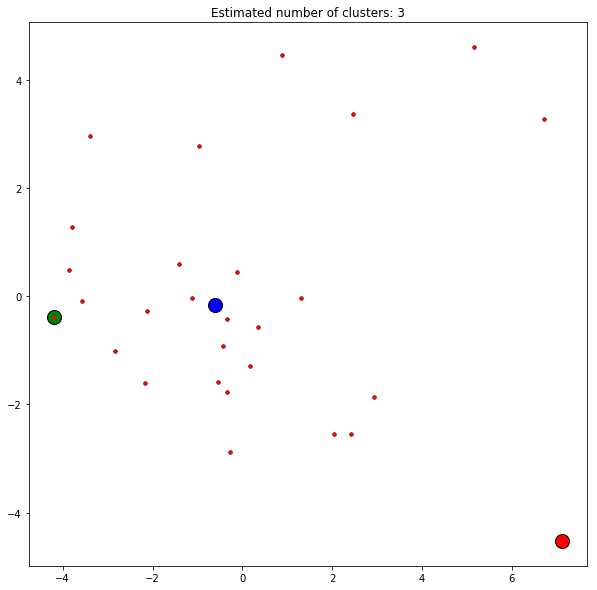

In [19]:
#plot result
plt.figure(1, figsize=(10,10))
plt.clf()

colors=cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(pca_df.PC1, pca_df.PC2, col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### Hierarchical Clustering

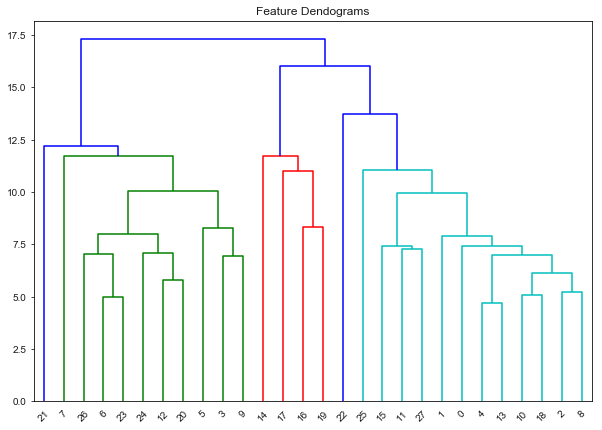

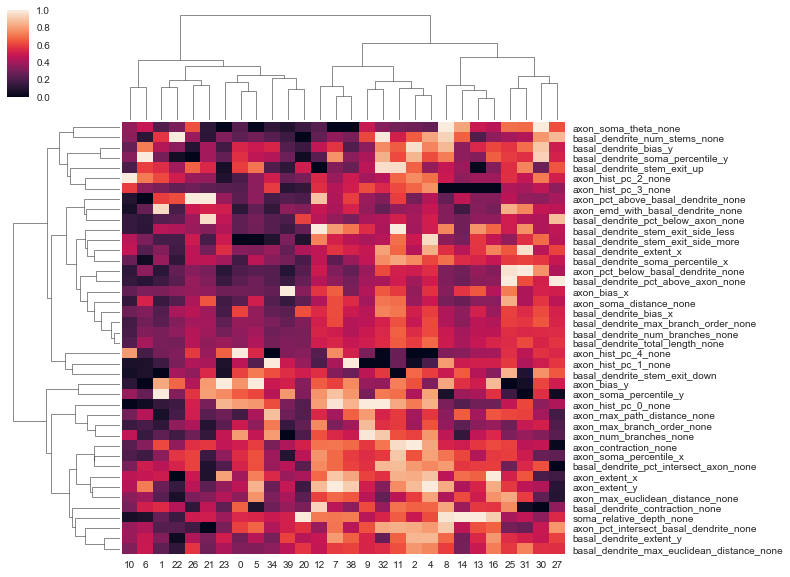

In [20]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10,7))
plt.title("Feature Dendograms")
dend = shc.dendrogram(shc.linkage(scaled_data, metric = 'euclidean', method='ward'))

sns.set(color_codes=True)
plt.figure(figsize=(10,16))
g = sns.clustermap(as_df.iloc[:,1:].transpose(), standard_scale = 1, metric='euclidean', method='ward')

Text(0,0.5,u'PC2 - 11.6%')

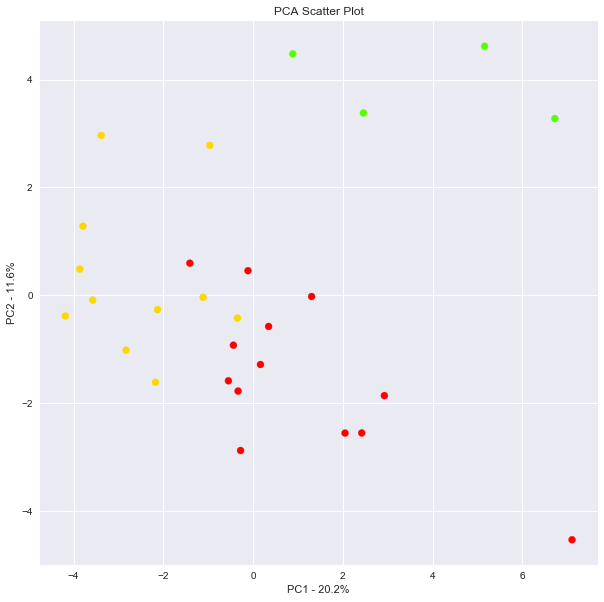

In [27]:
agg_cluster = skc.AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
agg_cluster.fit(pca_df)

plt.figure(figsize=(10,10))
plt.scatter(pca_df.PC1, pca_df.PC2, c=agg_cluster.labels_, cmap='prism')
plt.title('PCA Scatter Plot')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

### Spectral clustering

/Users/justinlee/anaconda2/lib/python2.7/site-packages/sklearn/cluster/spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


Text(0,0.5,u'PC2 - 11.6%')

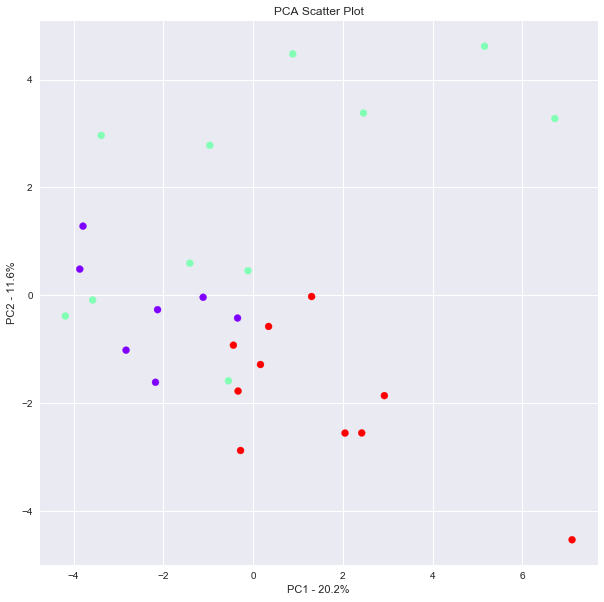

In [22]:
spec_cluster = skc.SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=10)
spec_cluster.fit_predict(pca_df)

plt.figure(figsize=(10,10))
plt.scatter(pca_df.PC1, pca_df.PC2, c=spec_cluster.labels_, cmap='rainbow')
plt.title('PCA Scatter Plot')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

### Comparing Clustering Methods

In [23]:
clusters = pd.DataFrame([qc['cell_specimen_id'].reset_index(drop=True), kM_cluster.labels_, ms_cluster.labels_, agg_cluster.labels_,
                       spec_cluster.labels_, 
                         qc['Morpho type'].reset_index(drop=True)]).transpose()
clusters.columns=['specimen_id', 'k-Means', 'Mean-Shift', 'Hierarchical', 
                  'Spectral', 
                  'Morpho type']
clusters

,specimen_id,k-Means,Mean-Shift,Hierarchical,Spectral,Morpho type
0,488386504,1,0,0,2,BC - STELLATE
1,488386626,1,0,0,1,BC - BITUFT
2,488418027,1,0,0,1,BC - BITUFT
3,526734407,1,0,1,0,BC - STELLATE
4,528687520,1,0,0,1,BC - STELLATE
5,529807751,1,0,1,1,BC - BITUFT
6,531520637,1,0,1,0,BC - STELLATE
7,539640410,1,0,1,1,BC - STELLATE
8,541536216,1,0,0,2,BC - BITUFT
9,545604343,1,0,1,1,BIC


In [24]:
display(pd.crosstab(clusters['k-Means'], clusters['Morpho type']))
display(pd.crosstab(clusters['Mean-Shift'], clusters['Morpho type']))
display(pd.crosstab(clusters['Hierarchical'], clusters['Morpho type']))
display(pd.crosstab(clusters['Spectral'], clusters['Morpho type']))

Morpho type,BC - BITUFT,BC - STELLATE,BIC
k-Means,,,
0,1,1,4
1,8,9,5


Morpho type,BC - BITUFT,BC - STELLATE,BIC
Mean-Shift,,,
0,8,10,8
1,1,0,0
2,0,0,1


Morpho type,BC - BITUFT,BC - STELLATE,BIC
Hierarchical,,,
0,4,5,8
1,5,5,1


Morpho type,BC - BITUFT,BC - STELLATE,BIC
Spectral,,,
0,3,4,0
1,5,2,4
2,1,4,5


The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. An index of 1.0 is a perfect match and index close to 0.0 represents random independent labeling.

In [25]:
from sklearn.metrics import adjusted_rand_score
for col in clusters.iloc[:,1:-1]:
    print(col, adjusted_rand_score(clusters[col], clusters['Morpho type']))
    
rand_idx = pd.DataFrame(data = {'Algorithm' : ['k-Means', 'Mean-Shift', 'Hierarchical', 'Spectral'], '2' : [0.1452, 'N/A', 0.0514, -0.0048], '3' : [0.0058, 0.0034, 0.0350, 0.0558], '4' : ['NA', 'NA', 'NA', 'NA'], '5' : ['NA', 'N/A', 0.0221, 'N/A']})
rand_idx.replace('N/A',np.NaN)

('k-Means', 0.036610169491525464)
('Mean-Shift', 0.0033616768835277272)
('Hierarchical', 0.051442910915934739)
('Spectral', 0.055766423357664276)


,2,3,4,5,Algorithm
0,0.1452,0.0058,NA,NA,k-Means
1,NaN,0.0034,NA,NaN,Mean-Shift
2,0.0514,0.0350,NA,0.0221,Hierarchical
3,-0.0048,0.0558,NA,NaN,Spectral


K-Means is detected the two major morpho types but similarity drops off when trying to detect the subtypes of BC cells.  
Mean-Shift appears very poor. Perhaps due to fairly equal variance in data and small sample size.   
We made a qualitative assumption of number of clusters for Hierarchical (Agglomerative) Clustering. Three was used to find match our qualitative calls but using only two yielded a higher random index. This suggests that the clustering method can better detect the two major morpho types rather than the subtypes.   
Spectral seems to detect the three "subtypes" better than the two major types but the large difference in rand index and fact that the rand index is negative for two clusters are likely due to the spread of the data being more angular. 

K-Means and then Hierarchical Clustering appear to be relatively the best algorithms for the given data; both algorithms are still not ideal considering their low rand indices. 
K-Means used two clusters which is consistent to the assumption that there are really two main aspiny neuron types (BC and BIC) and our qualitative calls have accounted for two prominent sub-types of basket cells.
Hierarchical clustering suggested five clusters in the dendrogram but it was to account for two outliers. So that leaves three prominent clusters which is consistent with our presumed morpho types

In [26]:
for i in clusters.iloc[:,1:-1]:
    for j in clusters.iloc[:,2:-1]:
        print(i, j, adjusted_rand_score(clusters[i], clusters[j]))

('k-Means', 'Mean-Shift', 0.11476992384425616)
('k-Means', 'Hierarchical', 0.0074142724745134125)
('k-Means', 'Spectral', 0.069247670278051357)
('Mean-Shift', 'Mean-Shift', 1.0)
('Mean-Shift', 'Hierarchical', 0.0083218144376429378)
('Mean-Shift', 'Spectral', -0.017100669349996638)
('Hierarchical', 'Mean-Shift', 0.0083218144376429378)
('Hierarchical', 'Hierarchical', 1.0)
('Hierarchical', 'Spectral', 0.33586189586412696)
('Spectral', 'Mean-Shift', -0.017100669349996638)
('Spectral', 'Hierarchical', 0.33586189586412696)
('Spectral', 'Spectral', 1.0)
